# Background

This brief notebook provides some background material on FT8 and some of the theoretical concepts that will
be useful in understanding how FT8 signals are received and transmitted.

This notebook uses the following libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal
import ft8

## What Is FT8?

FT8 is a digital communication mode used by amateur radio operators.
It was first introduced in 2017 as part of the WSJT-X program that is developed by Dr. Joe Taylor (K1JT)
and his collaborators [[1](#References)].

Key features of the FT8 digital mode are:

* Short, highly structured QSOs, lasting 1-2 minutes
* Alternating transmit and receive cycles, each of 15 seconds duration
* Highly robust in the presence of noise
* QSOs possible at SNRs lower than -20dB (measured in a 2.5kHz bandwidth)
* Originally designed to take advantage of Sporadic E propagation
* Builds upon ideas developed by earlier digital modes such as JT65

![WSJT-X User Interface](images/wsjtxui.png)

## Fourier Analysis

Named after Joseph Fourier, the french mathematician who proposed that mathematical functions can be decomposed into a sum of sine functions in a 1807 paper on heat transfer [[2](#References)].

WSJT-X makes extensive use of a tool from Fourier analysis called the Discrete Fourier Transform (DFT).
This transform takes time domain representations of signals (what you would see on an oscilloscope) and converts them to frequency domain representations (what you would see on a spectrum analyser).

Computing the DFT of a sequence of samples is computationally expensive, and therefore the DFT was not widely
used until 1965 when a method for rapidly computing the DFT become widely known after it was disclosed in a
paper by Cooley and Tukey [[3](#References)].
This method for computing the DFT is now known as the fast Fourier transform (FFT) algorithm.

WSJT-X uses a particular implementation of the FFT algorithm called
"The Fastest Fourier Transform in the West" (FFTW),
that was originally developed in the mid-1990s by Frigo and Johnson while they were students at MIT
[[4](#References)].

The following example illustrates how the DFT can be used to convert a time domain representation of a signal
to a frequency domain representation using the Python scipy implementation of the FFT algorithm.

In [2]:
def fourier_example():

    plt.figure(figsize = (14,7))
    
    # Generate a noisy signal
    duration = 1
    points = 256
    t = np.linspace(0, duration, points)
    noise_sigma = 2.0
    n = np.random.normal(0, noise_sigma, t.size) + 0.1
    frequency = 20.0
    amplitude = 10.0 * np.sqrt(2.0)
    s = amplitude * np.cos(2 * np.pi * frequency * t)
    
    # Time domain view of signal with noise
    ax1 = plt.subplot(121)
    ax1.set(xlabel='Seconds', ylabel='Volts')
    ax1.set_title('Time Domain Representation')
    plt.plot(t, s + n)
    
    # Calculate the spectrum of the signal with noise
    f, spectrum = scipy.signal.periodogram(s + n, points / duration, 'flattop', scaling='spectrum')
    
    # Frequency domain view of the signal with noise
    ax2 = plt.subplot(122)
    ax2.set(xlabel='Hertz', ylabel='dBV')
    ax2.set_title('Frequency Domain Representation')
    plt.plot(f, 10 * np.log10(spectrum))

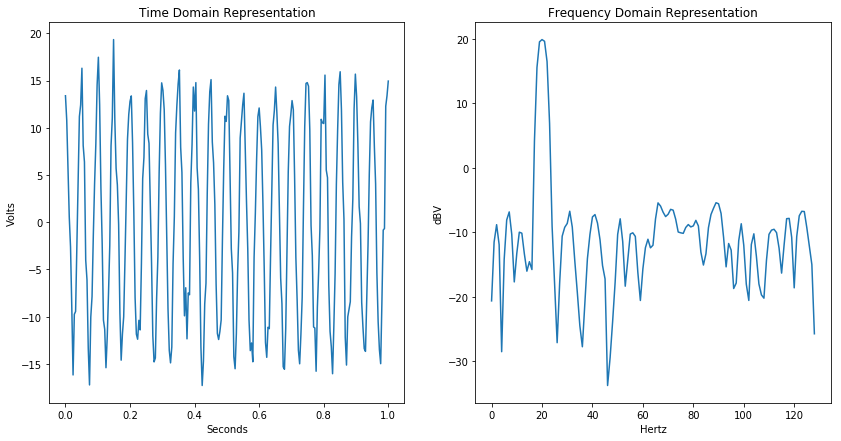

In [3]:
fourier_example()

## Information Theory

In a 1948 paper [[5](#References)], Claude Shannon described how messages could be sent over noisy communications
channels with an arbitrarily small probability of error,
provided those messages were sent at a suitable speed, and with suitable encoding.

Shannon showed that there was a "speed limit" for sending messages with arbitrarily small probability of error,
which he named the **channel capacity**.
The channel capacity defines how fast **information** can be sent across a particular communications channel.
Shannon defines the information content of a message mathematically in his paper,
as a measure of how unexpected that message might be - unexpected messages contain more information than messages that were expected.

Shannon's paper spawned an entire field of research called **information theory** which is the theoretical
basis for modern digital communications systems.

The model used in information theory for digital communication systems is illustrated below:

![Communication Model](drawings/Communication%20Model.svg)

Messages are first subject to *source encoding* to remove redundancy and represent the message using a
minimal number of bits.
Source encoding is sometimes called *data compression*.
A perfect source encoding scheme reduces the message to a number of bits that is equal to the information
content of the message.

The source encoding used for the FT8 digital mode by WSJT-X is a unique packing developed by the primary WSJT-X
author, Dr. Joe Taylor (K1JT),
that is similar (but not identical) to that used in the earlier JT65 digital mode.

After messages are compressed using source encoding, they are then subject to channel encoding to enable
correction of errors introduced by noise in the communcation channel.

The channel encoding used by WSJT-X for FT8 involves 3 different codes,
an error detection code (CRC code [[6](#References)]),
a forward error correction code (LDPC code [[7](#References)]),
and a code to minimise the introduction of errors when converting from the analog to digital domains
at the receiver (Gray code [[8](#References)]).

## Costas Arrays

Costas arrays are a mathematical construct named after John Costas who first proposed them in the 1960s
to improve the capability of SONAR systems [[9](#References)][[10](#References)].

Costas arrays are comprised of a grid of points with one point in each row and column.
The defining property for Costas arrays is that the displacement vectors (distance and direction) between any
pair of points in the array are distinct i.e. different to that of any other pair of points.

WSJT-X uses Costas arrays to accurately identify the frequency and time offset of FT8 signals by
exploiting their distinct auto-ambiguity function when the Costas array is used to generate a
sequence of tones - this is analogous to the determination of relative velocity (from doppler frequency shift)
and range (from time offset) in a SONAR or RADAR system.

The following example illustrates the Costas array used in the FT8 digital mode, along with its
auto-ambiguity function:

In [10]:
def costas_example():
    
    plt.figure(figsize=(14, 7))
    
    # Plot the Costas array used by FT8    
    ax1 = plt.subplot(121)
    ax1.grid(True)
    ax1.set_title('FT8 Costas Array')
    ax1.set(xlabel='Time', ylabel='Frequency')
    plt.scatter(np.arange(ft8.costas_order), ft8.costas, 1000)
    
    # Calculate the auto-ambiguity
    array = np.zeros((ft8.costas_order, ft8.costas_order))
    for t, f in enumerate(ft8.costas):
        array[t,f] = 1.0
    auto = scipy.signal.correlate(np.pad(array, 5, mode='constant'), array)

    # Plot auto-ambiguity
    ax2 = plt.subplot(122, projection='3d')
    x, y = np.meshgrid(np.arange(auto.shape[0]) - 7 - 5, np.arange(auto.shape[1]) - 7 - 5)
    ax2.set(xlabel='Time Offset', ylabel='Frequency Offset', zlabel='Overlapping Points')
    ax2.plot_surface(x, y, auto, linewidth=0, cmap=plt.get_cmap('coolwarm'))

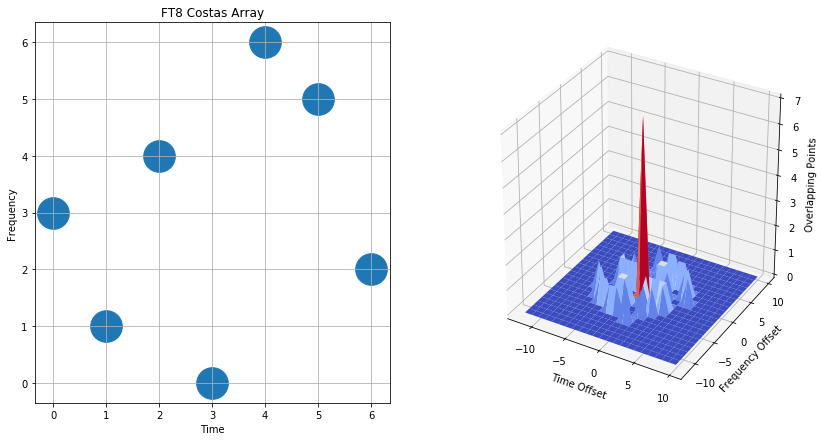

In [11]:
costas_example()

## References

1. https://physics.princeton.edu/pulsar/k1jt/wsjtx.html
1. Fourier, "Mémoire sur la propagation de la chaleur dans les corps solides," Nouveau Boulletin des Sciences, vol. 1, pp. 112-116, 1807.
1. James W. Cooley and John W. Tukey, "An Algorithm for the Machine Computation of Complex Fourier Series," Mathematics of Computation, vol. 19, pp. 297-301, Apr. 1965.
1. Matteo Frigo and Steven G. Johnson, "The Design and Implementation of FFTW3," Proceedings of the IEEE, vol. 93, pp. 216–231, Feb. 2005.
1. C. E. Shannon, "A Mathematical Theory of Communication," The Bell System Technical Journal, vol. 27, pp. 379-423, Jul. 1948.
1. W. W. Peterson and D. T. Brown, "Cyclic Codes for Error Detection,", Proceedings of the IRE, vol. 49, pp. 228-235, Jan. 1961.
1. R. G. Gallager, "Low-Density Parity-Check Codes," IRE Transactions on Information Theory, vol. 8, pp. 21-28, Jan. 1962.
1. Frank Gray, "Pulse Code Communication," U.S. Patent 2,632,058, filed 13 Nov. 1947, issued 17 Mar. 1953.
1. J. P. Costas, “Medium constraints on SONAR design and performance,” GE Co., Class 1 Rep. R65EMH33, Nov. 1965.
1. John P. Costas, "A Study of a Class of Detection Waveforms Having Nearly Ideal Range-Doppler Ambiguity Properties," Proceedings of the IEEE, vol. 72, pp. 996-1009, Aug. 1984.

## License
Copyright (C) 2019 James Kelly, VK3JPK.

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.